In [1]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import pickle
from recipe_loading import *
from qty_mapping import *
from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import *
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib

The steps followed here are:

1) Load 1m recipe
2) Standardise the units
3) Load density info
4) Calculate the required amount of each ingredient

In [2]:
from pathlib import Path
PATH = Path("")
data_path = PATH.home()/'data/Target/data/'
model_path = PATH.home()/'data/Target/models/group10'
recipe_path = data_path/"layer1.json"
recipe_image_path = data_path/"layer2.json"
op_file_path = data_path/"ing_density.csv"

# Load recipes
with open(recipe_path) as json_data:
    recipe = json.load(json_data)

In [3]:
# Load recipe images
with open(recipe_image_path) as json_data:
    recipe_images = json.load(json_data)

In [4]:
# Get grocery product hierarchy information
group10 = pd.read_csv(data_path/'group10_header.csv',
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(data_path/'products.csv')

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

# Fill NAs
group10 = fillNa(group10)

In [5]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
    return stored_data
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df


In [6]:
k=3

# Bi Encoder
multi_lm_embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
# Cross encoder 
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-4-v2', max_length=512)

In [7]:
# Classification models
pm = Mapper(group10)
clf_name_class_name = model_path/'nli-classification-class_name'
clf_name_item_type_name = model_path/'nli-classification-item_type_name'
clf_name_subclass_name = model_path/'nli-classification-subclass_name'
base_clf_class_name = CrossEncoder(clf_name_class_name)
base_clf_item_type_name = CrossEncoder(clf_name_item_type_name)
base_clf_subclass_name = CrossEncoder(clf_name_subclass_name)
clf_class_name = Classifier(base_clf_class_name, pm, 'class_name', threshold=0.98)
clf_item_type_name = Classifier(base_clf_item_type_name, pm, 'item_type_name', threshold=0.99)
clf_subclass_name = Classifier(base_clf_subclass_name, pm, 'subclass_name', threshold=0.99)

In [8]:
multi_lm_embeddings = get_embeddings(data_path/'hier_embeddings.pkl')

In [9]:
filtered_products = list(group10[~pd.isnull(group10['image'])]['tcin'].values)

# Bi encoder without classifier
multi_lm = TransformerRanker(model=multi_lm_embedder, max_rank=k, 
                            filtered_products=filtered_products)
multi_lm.load_embeddings(multi_lm_embeddings)

# Bi encoder with classifier
multi_lm_clf = TransformerRanker(model=multi_lm_embedder,
                                max_rank=k, clf=[clf_class_name, 
                                                clf_item_type_name,
                                                clf_subclass_name],
                                filtered_products=filtered_products)
multi_lm_clf.load_embeddings(multi_lm_embeddings)

# Cross encoder with classifier
cr_multi_lm_clf = CrossEncoderRanker(bi_model=multi_lm_clf, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map(data_path/'hier_embeddings.pkl'),
                        cross_rank=k,
                        bi_rank=30,
                        mapper=pm,
                        weights=True)  

# Cross encoder without classifier
cr_multi_lm = CrossEncoderRanker(bi_model=multi_lm, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map(data_path/'hier_embeddings.pkl'),
                        cross_rank=k,
                        bi_rank=30,
                        mapper=pm,
                        weights=True)  

In [10]:
# Load BM25 (For ingredients)
bm25 = joblib.load(model_path/'bm25_no_description')

In [11]:
rc = RankerCombination([bm25, multi_lm_clf], [0.4, 0.6], max_rank=10)
l2_ranker = RankerPipeline([rc, cr_multi_lm], [10, k])

In [12]:
# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values
pm = Mapper(group10)
dp = DisplayProducts(ranker=l2_ranker, mapper=pm)

In [13]:
# Get random recipe from the 1M recipe corpus
i = random.randint(0, 1000000)
i=218763
print(i)
id, dict_ingredients= recipe_load_index(i, recipe)
df_combined_ing = pd.DataFrame.from_dict(dict_ingredients)
df_combined_ing['quantity'] = df_combined_ing['quantity'].apply(convert_fraction)

qty = Qty_normal_map(op_file_path= op_file_path, data=group10)

#normalise units
combined_ingredient_df=qty.normalize_units(df_combined_ing)

# required for multiple recipes - combining qty
combined_ingredient_df = qty.combine_qty(df_combined_ing)

#using density info calculating required ounces for each ingredient
final_df = qty.req_oz_recipe(combined_ingredient_df)


218763
Recipe: Steak Fajita Enchiladas


/Users/chahaksethi/Desktop/Target/target/target_recipe_project/code/notebook/qty_mapping.py:77: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  combined_ingredient_df['standard_vol'],combined_ingredient_df['standard_weight_gm'],\


In [14]:
combined_ingredient_df

,ingredient,normalized_unit,quantity,Volume_in_ml,tuple,standard_vol,standard_weight_gm,standard_unit
0,Mexican blend cheese,cup,2.0,450.0,"(1.0, 240.0, cup)",1.0,240.0,cup
1,all natural burrito-size flour tortillas,count,12.0,0.0,"(1.0, 100.0, cup)",1.0,100.0,cup
2,fresh salsa,cup,1.5,337.5,"(1.0, 100.0, cup)",1.0,100.0,cup
3,garlic,cloves,1.0,0.0,"(1.0, 2.0, teaspoon)",1.0,2.0,teaspoon
4,green pepper,count,1.0,0.0,"(1.0, 2.0, teaspoon)",1.0,2.0,teaspoon
5,large onion,count,12.0,0.0,"(1.0, 100.0, cup)",1.0,100.0,cup
6,oil,tsp,2.0,10.0,"(1.0, 100.0, cup)",1.0,100.0,cup
7,red bell peppers,count,2.0,0.0,"(1.0, 100.0, cup)",1.0,100.0,cup
8,simply organic fajita seasoning mix,tbsp,2.0,30.0,"(1.0, 100.0, cup)",1.0,100.0,cup
9,sliced grilled flank steaks,cup,3.0,675.0,"(1.0, 100.0, cup)",1.0,100.0,cup


In [15]:
recipe[i]

{'ingredients': [{'text': '1 green pepper, Thinly Sliced'},
  {'text': '2 red bell peppers'},
  {'text': '12 large onion, Thinly Sliced'},
  {'text': '1 garlic clove'},
  {'text': '2 tablespoons simply organic fajita seasoning mix'},
  {'text': '2 teaspoons oil'},
  {'text': '12 all natural burrito-size flour tortillas'},
  {'text': '3 cups sliced grilled flank steaks'},
  {'text': '1 12 cups fresh salsa'},
  {'text': '1 12 cups sour cream'},
  {'text': '2 cups Mexican blend cheese'}],
 'url': 'http://www.food.com/recipe/steak-fajita-enchiladas-525733',
 'partition': 'train',
 'title': 'Steak Fajita Enchiladas',
 'id': '3660316eee',
 'instructions': [{'text': 'Preheat Oven to 350.'},
  {'text': 'Heat skillet on Medium/high.'},
  {'text': 'Add 1 tbsp canola oil.'},
  {'text': 'Once hot, add garlic and stir frequently until lightly browned.'},
  {'text': 'Add onions and continue to saute.'},
  {'text': 'In large mixing bowl, Add fajita mix to 2T.'},
  {'text': 'warm water and 2 t. canola

In [16]:
import matplotlib.pyplot as plt
urls = []
for recipe_image in recipe_images:
    if recipe_image['id'] == id:
        for image in recipe_image['images']:
            urls.append(image['url'])
images = pm.get_images_urls(urls)

plt.figure(figsize=(20,10))
columns = 3
for i in range(len(images)):
    ax = plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
    plt.axis('off')
    # plt.title(titles[i])
    plt.imshow(images[i])

<Figure size 1440x720 with 0 Axes>

In [17]:
# Preprocess recipe ingredients
final_df['ingredient'] = preprocess(final_df['ingredient'])
recipe_ingredients = list(final_df['ingredient'].values)

# Ranked list of product tcin matches for each ingredient - Returns a list of lists 
ranked_match = l2_ranker.rank_products_recipe(recipe_ingredients)

#matching target database with recipe 
join_df = qty.match_ranked_ingredients(ranked_match , final_df, recipe_ingredients)

#calculating recommended quantity
rec_df = qty.recommended_quantity(join_df)
df = rec_df.sort_values(by=['ingredient', 'recommended_qty', 'price']).copy()
display_df = df[['tcin', 'ingredient', 'recommended_qty', 'price']].copy()

/Users/chahaksethi/Desktop/Target/target/target_recipe_project/code/notebook/ranker.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = torch.nn.functional.softmax(torch.tensor(scores)).numpy()


Filtered all natural burrito size flour tortillas burrito flour tortillas for class_name: MEXICAN/BADIA/GOYA
Filtered all natural burrito size flour tortillas burrito flour tortillas for item_type_name: Tortillas and Taco Shells
Filtered fresh salsa salsa for class_name: MEXICAN/BADIA/GOYA
Filtered red bell peppers peppers for class_name: MAIN VEGETABLE
Filtered sour cream cream for class_name: CULTURED PRODUCTS


all natural burrito size flour tortillas
[13356634 51422567 47087882]


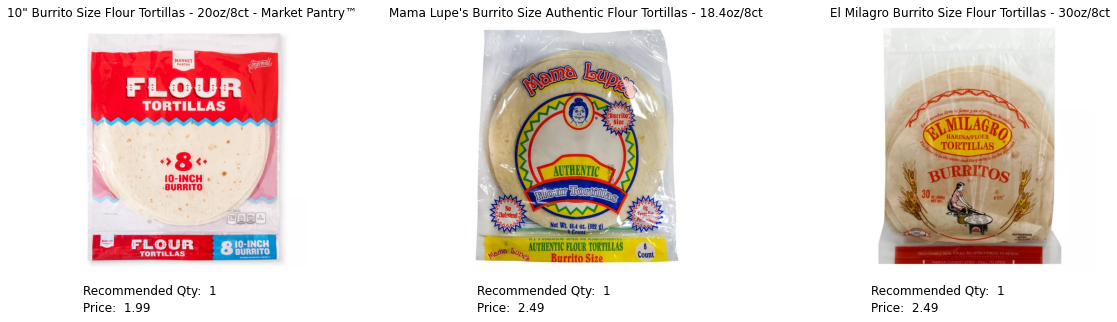

fresh salsa
[79499578 79500480 79500064]


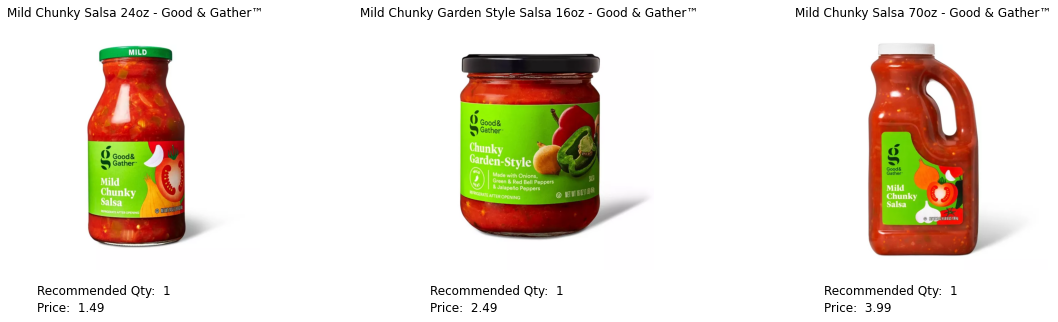

garlic
[14917452 15416581 13556562]


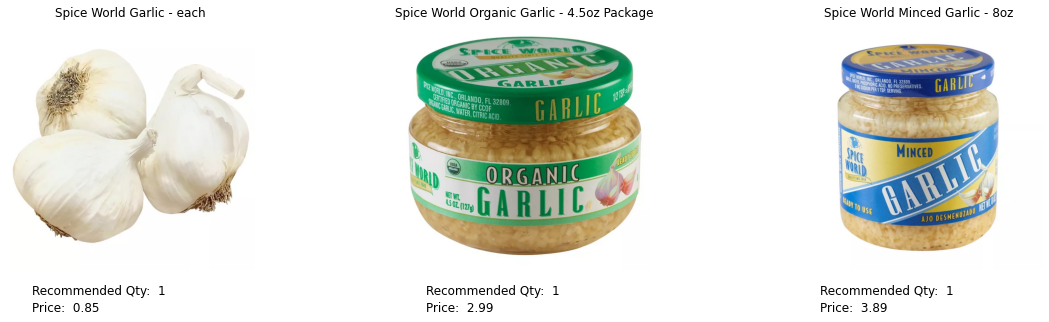

green pepper
[14919034 14919665 15293786]


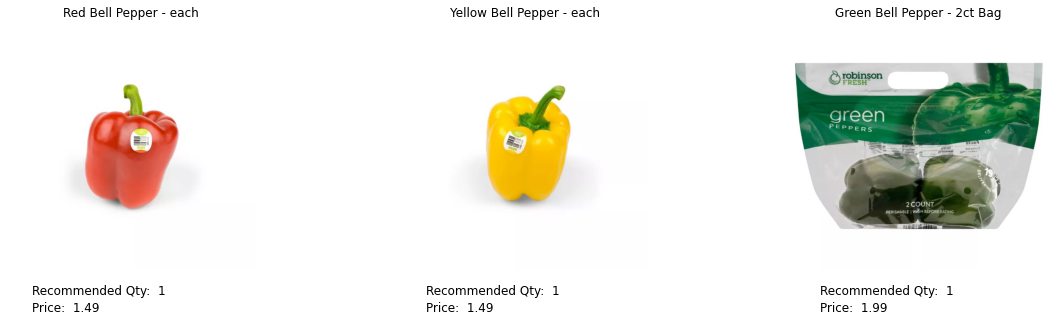

large onion
[13474244 14917313 14917361]


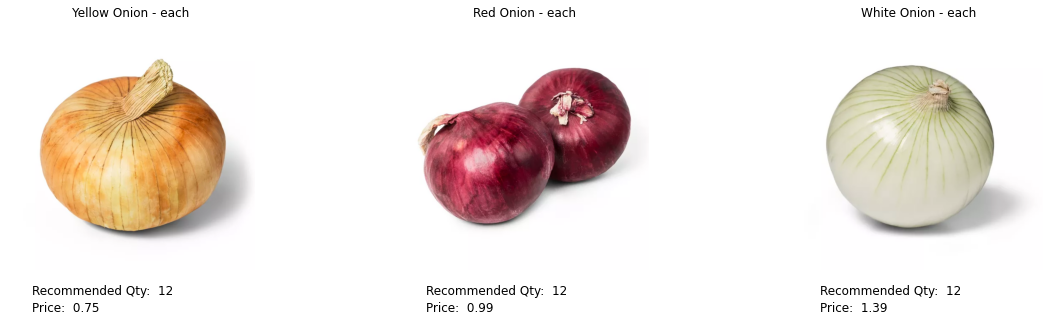

mexican blend cheese
[78053138 47104930 52252119]


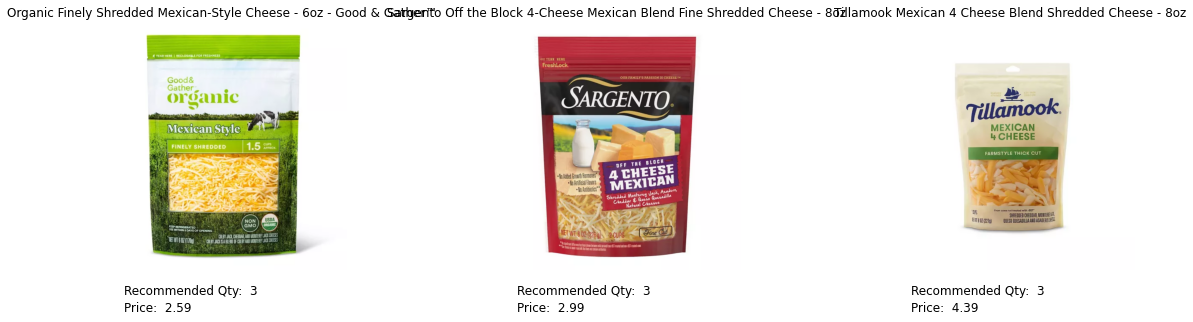

oil
[15365078 15365079 77600243]


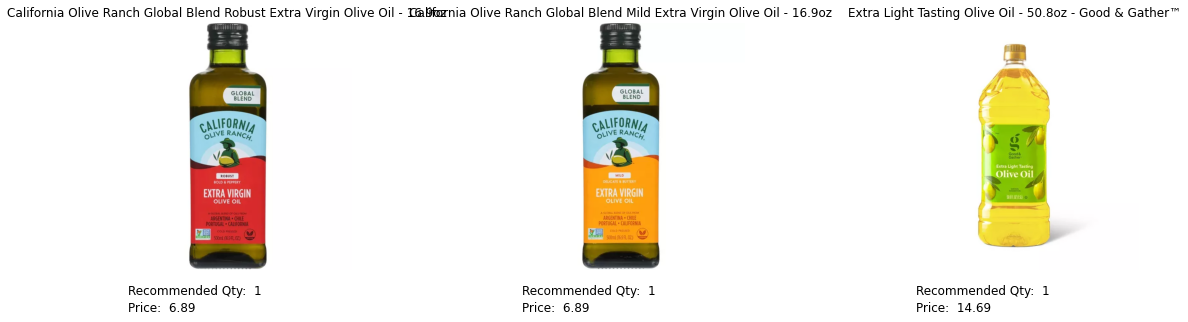

red bell peppers
[14919665 78832378 14919034]


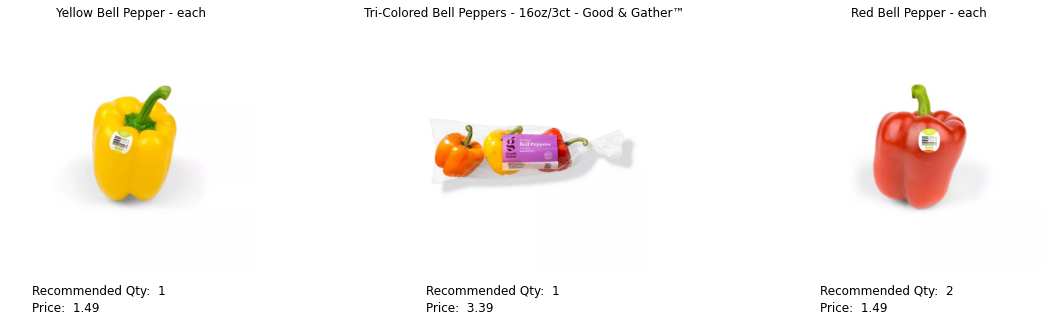

simply organic fajita seasoning mix
[13388905 13391875 79517529]


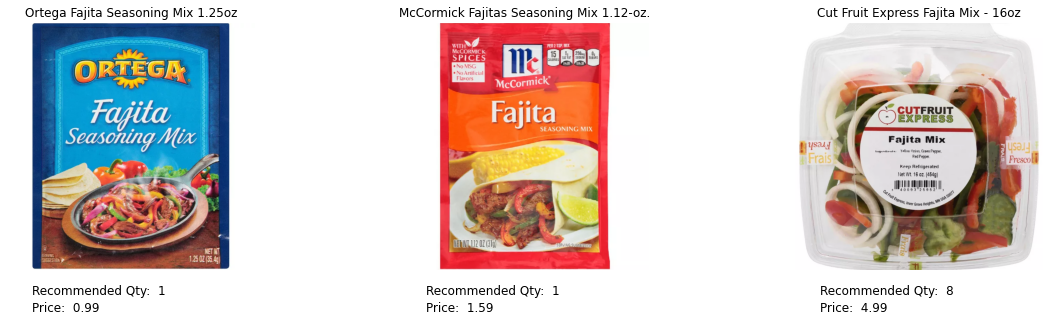

sliced grilled flank steaks
[14911556 14704224 77588744]


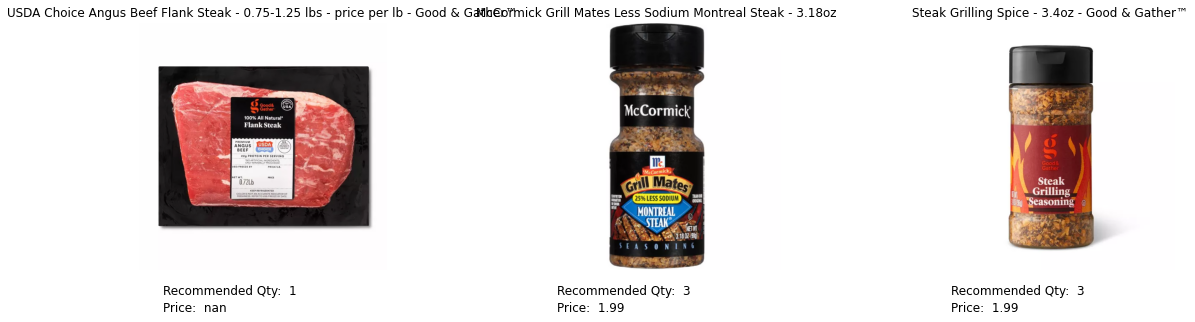

sour cream
[79556007 79556008 21510127]


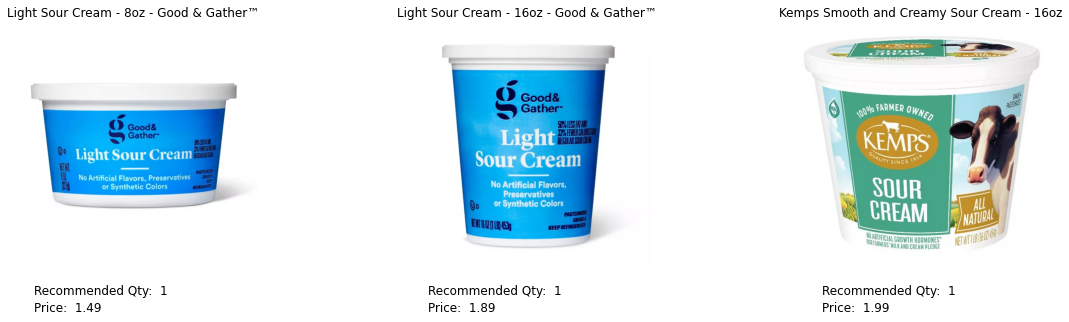

In [18]:
dp.display_products_df(display_df, 3)

/Users/chahaksethi/Desktop/Target/target/target_recipe_project/code/notebook/ranker.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = torch.nn.functional.softmax(torch.tensor(scores)).numpy()


Filtered unsalted butter butter for class_name: BUTTER
[80796340, 54534326, 54446566, 13227053, 14729229, 14729228, 14729227, 49110709, 80796339, 13422552]


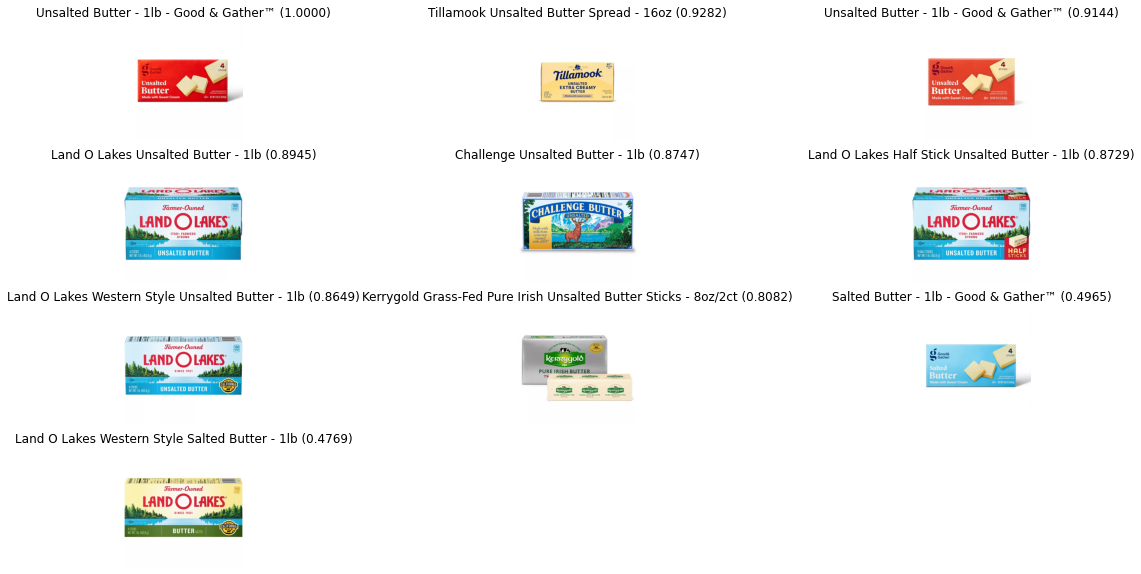

In [ ]:
product_scores = rc.get_scores_ingredient('unsalted butter')
dp.display_products_ingredient_score(product_scores)

In [23]:
#fine

#4567
#7609
#32659
#4623
#17864
#7124
#87364

# Both
# 82314
# 24513

In [ ]:
# problems

# 83468 - only first matches correct
# 83642 - no dairy free
# 7362 - sliced pepporoni
# 21312 - 